# BirdNet sandbox code
This is a small collection of code to manipulate and analyse recording of bird song using the BirdNet Analyzer model to classify bird species based on recordings. The code is intended for use using Google Colab but can be easily altered for use on a local machine.  

In [1]:
!git clone https://github.com/weharris/birdnetTest

Cloning into 'birdnetTest'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 114 (delta 36), reused 52 (delta 21), pack-reused 46
Receiving objects: 100% (114/114), 684.34 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (22/22), done.


In [2]:
cd birdnetTest/

/content/birdnetTest


In [3]:
!pip3 install birdnetlib
!pip3 install tflite-runtime
!pip3 install resampy
!pip3 install ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=170420808c8110769074fdc02182881388d8de7e92e06a7eb31b9ff2908fac97
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [4]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime

## Code for a single recording

In [10]:
# This celluses BirdNET-Analyzer to analyze a single recording.
# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

testamp = [52.911,-2.4441] # near Market Drayton year=2024, month=4, day=5
xc558223 = [57.4706, -4.163] # Highlands Scotland 2020-05-14 4am year=2020, month=5, day=14
XC553677 = [54.1212, -0.5416] # Ryedale District,(near Helperthorpe) North Yorkshire 2020-05-01 5:10a year=2020, month=5, day=1

recording = Recording(
    analyzer,
    "data/EdH20240420/testamp.mp3",  # path to the recording file
    lat=testamp[0], # latitude of the recording location
    lon=testamp[1], # longitude of the recording location
    date=datetime(year=2024, month=4, day=20), # use date or week_48
    min_conf=0.25,
)
recording.analyze()

myDetections = recording.detections

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  22 chunks.
analyze_recording testamp.mp3
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
15
145 species loaded.


In [ ]:
# for Single File and list of spp and counts
import pandas as pd

species_count = {}
for entry in myDetections:
    common_name = entry['common_name']
    if common_name in species_count:
        species_count[common_name] += 1
    else:
        species_count[common_name] = 1

df = pd.DataFrame(list(species_count.items()), columns=['Common Name', 'Count'])

sorted_df = df.sort_values('Common Name')
# sorted_df = df.sort_values('Count', ascending=False)
sorted_df.head()

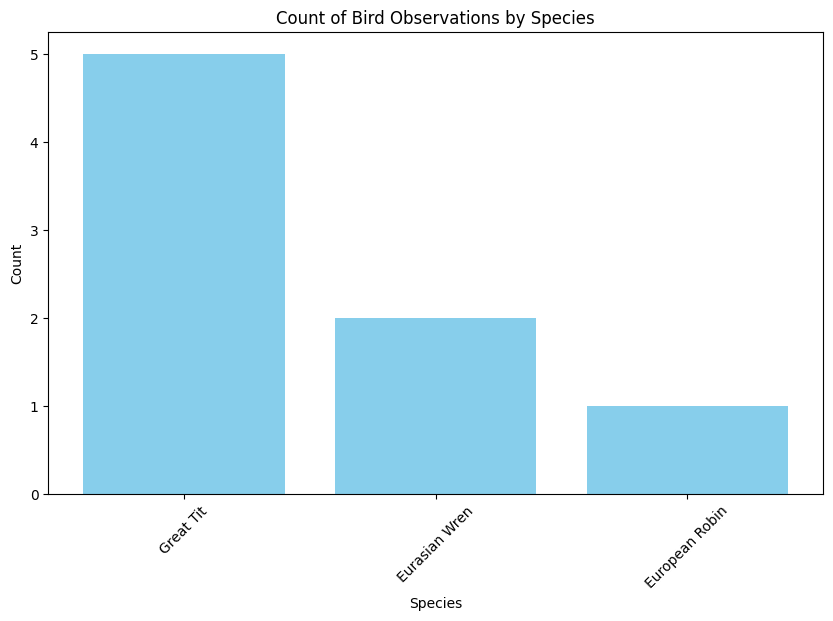

In [22]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(df['Common Name'], df['Count'], color='skyblue')  # Create a bar plot
plt.xlabel('Species')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Count of Bird Observations by Species')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

## Code for multiple recordings

In [ ]:
# This cell reads sound files from a directory you are prompted to specify
# that contains multiple files you want to analyse
%run scripts/dataFiles.py

print(len(file_names), " files")

file_names = sorted(file_names)
print(file_names)
# print(len(file_names), " files")
# print(file_names)

In [ ]:
# This cell uses BirdNET-Analyzer to analyze multiple recordings.
# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

testamp = [52.911,-2.4441] # near Market Drayton year=2024, month=4, day=20

# Create a dictionary to store the results
results = {}

# Loop through all file names
for file_name in file_names:
    # Include the correct path to the data files
    file_path = os.path.join('data', file_name)
    recording = Recording(
        analyzer,
        file_path,  # path to the recording file
        lat=testamp[0], # latitude of the recording location
        lon=testamp[1], # longitude of the recording location
        date=datetime(year=2024, month=4, day=20), # use date or week_48
        min_conf=0.25,
    )
    # Analyze the recording and store the result in the dictionary
    recording.analyze()
    results[file_name] = recording.detections

In [ ]:
# for Multiple Files and list of spp and counts
import pandas as pd

# Convert the nested dictionaries into a list of dictionaries
data = []
for file_name, detections in results.items():
    for detection in detections:
        detection['file_name'] = file_name  # Add the file name to the detection dictionary
        data.append(detection)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Group by file_name and common_name, and count the number of detections for each
counts = df.groupby(['common_name','file_name' ]).size().unstack(fill_value=0)

# The result is a DataFrame where each row corresponds to a file, each column corresponds to a bird species,
# and the cell values are the counts of detections for each species in each file

print(counts)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Create a dictionary that maps the old labels to the new labels
new_labels = {'BAT01_20240420_080000.wav': '08:00',
              'BAT01_20240420_090000.wav': '09:00',
              'BAT01_20240420_100000.wav': '10:00',
              'BAT01_20240420_110000.wav': '11:00',
              'BAT01_20240420_120000.wav': '12:00',
              'BAT01_20240420_130000.wav': '13:00',
              'BAT01_20240420_140000.wav': '14:00',
              'BAT01_20240420_150000.wav': '15:00',
              'BAT01_20240420_160000.wav': '16:00'}

# Replace the column names of the DataFrame
counts.rename(columns=new_labels, inplace=True)

# Sum the counts for each species and sort in descending order
sorted_species = counts.sum(axis=1).sort_values(ascending=False).index

# Reorder the rows of the DataFrame
counts = counts.loc[sorted_species]

# Create a larger figure to accommodate the plot
plt.figure(figsize=(10, len(counts.index) * 0.2))  # Adjust the size as needed

# Create a colormap that uses gray for zero detections
cmap = colors.ListedColormap(sns.color_palette("YlGnBu", 256))
cmap.set_under((0.85, 0.85, 0.85))  # Light gray
#cmap.set_under("gray")

# Create the heatmap
sns.heatmap(counts, cmap=cmap, vmin=0.01)  # Set vmin to a small value so that zero detections are colored gray

plt.title('Bird species detections per hour')
plt.ylabel('Species')
plt.xlabel('Time')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# Move the x-axis labels to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of detections for each file
new_labels = {'BAT01_20240420_080000.wav': '08:00',
              'BAT01_20240420_090000.wav': '09:00',
              'BAT01_20240420_100000.wav': '10:00',
              'BAT01_20240420_110000.wav': '11:00',
              'BAT01_20240420_120000.wav': '12:00',
              'BAT01_20240420_130000.wav': '13:00',
              'BAT01_20240420_140000.wav': '14:00',
              'BAT01_20240420_150000.wav': '15:00',
              'BAT01_20240420_160000.wav': '16:00'}

# Assuming df2 is your DataFrame and 'file_name' is the column with the filenames
df2['file_name'] = df2['file_name'].replace(new_labels)

detections = df2.groupby('file_name').size()

# Create a bar plot
detections.plot(kind='bar')

# Set the title and labels
plt.title('Number of Detections by Time')
plt.xlabel('Time')
plt.ylabel('Number of Detections')

# Show the plot
plt.show()

## Miscellaneous code

In [ ]:
# check a few confidence values
# convert data to data frame
import pandas as pd

# Flatten the results into a list of dictionaries
flattened_results = [item for sublist in results.values() for item in sublist]

# Convert the list of dictionaries to a DataFrame
df2 = pd.DataFrame(flattened_results)
df2.head()

In [ ]:
mean_confidence = df2.groupby('common_name')['confidence'].mean()
sorted_mean_confidence = mean_confidence.sort_values(ascending=False)
print(sorted_mean_confidence)

In [ ]:
# Species accumulation curve
import matplotlib.pyplot as plt

new_labels = {'BAT01_20240420_080000.wav': '08:00',
              'BAT01_20240420_090000.wav': '09:00',
              'BAT01_20240420_100000.wav': '10:00',
              'BAT01_20240420_110000.wav': '11:00',
              'BAT01_20240420_120000.wav': '12:00',
              'BAT01_20240420_130000.wav': '13:00',
              'BAT01_20240420_140000.wav': '14:00',
              'BAT01_20240420_150000.wav': '15:00',
              'BAT01_20240420_160000.wav': '16:00'}

# Assuming counts is your DataFrame
counts.rename(columns=new_labels, inplace=True)


# Convert the presence/absence data to boolean
presence = counts > 0

# Calculate the cumulative sum of the boolean data over time
cumulative_presence = presence.cumsum(axis=1)

# Convert the cumulative sum to boolean
cumulative_presence = cumulative_presence > 0

# Calculate the sum of the boolean data over species
unique_species = cumulative_presence.sum()

# Plot the number of unique species over time
unique_species.plot()

# Set the title and labels
plt.title('Species Accumulation Curve')
plt.xlabel('Sampling Period')
plt.ylabel('Number of Unique Species')
# Angle the labels on the x-axis
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Extract confidence values for "Great Tit"
confidence_testamp = [entry['confidence'] for entry in testamp if entry['common_name'] == 'Great Tit']
confidence_test = [entry['confidence'] for entry in test if entry['common_name'] == 'Great Tit']

# Create DataFrame for plotting
data = {
    "testamp": confidence_testamp,
    "test": confidence_test
}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 6))
df.boxplot(column=['testamp', 'test'])
plt.ylabel('Confidence')
plt.title('Confidence Levels for Great Tit Observations')
plt.show()



In [ ]:
# Perform a t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(confidence_testamp, confidence_test, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

## Sources
https://github.com/kahst/BirdNET-Analyzer?tab=readme-ov-file#62-setup-birdnetlib